# Análisis de Componentes Principales (PCA) en el Dataset de Enfermedad Cardíaca

**Curso:** Inteligencia Artificial II  
**Profesor:** Dr. Andrés Hernández Gutiérrez  
**Fecha de entrega:** 16 de febrero de 2026  

Este trabajo aplica Análisis de Componentes Principales (PCA) al dataset de enfermedad cardíaca de UCI. El objetivo es reducir la dimensionalidad de los datos y visualizar patrones que puedan ayudar en futuros modelos de clasificación.

In [152]:
# Importo las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuro el estilo de los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Descripción del dataset y análisis exploratorio

### 1.1 Carga del dataset

El dataset lo obtuve del repositorio UCI Machine Learning. El cuál tiene información de 303 pacientes y 14 variables, además de la variable objetivo `num` que indica la presencia de enfermedad cardíaca (0 = sin enfermedad, 1-4 = grados de enfermedad). Los valores faltantes están marcados con "?".

In [153]:
df = pd.read_csv('heart_disease_uci.csv')

print(f"Forma del Dataset: {df.shape[0]} filas, {df.shape[1]} columnas.")
print("\nPrimeras filas del dataset:")
df.head()

Forma del Dataset: 920 filas, 16 columnas.

Primeras filas del dataset:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### 1.2 Limpieza de datos

Primero verifico los valores nulos, y me doy cuenta de que las columnas `ca` y `thal` tienen algunos valores faltantes, aunqeu como son pocos, los imputare con la moda (valor más frecuente). Así evito eliminar filas y perder información.

In [154]:
# Imputo los valores nulos usando la moda (valor más frecuente) en 'ca' y 'thal'
moda_ca = df['ca'].mode()[0]
moda_thal = df['thal'].mode()[0]
df['ca'] = df['ca'].fillna(moda_ca)
df['thal'] = df['thal'].fillna(moda_thal)

print("\nValores nulos después de imputar:")
nulos_despues = df.isnull().sum()


Valores nulos después de imputar:


Como se puede ver en el output, ya no hay valores nulos restantes. El dataset está limpio.

### 1.3 Codificación de variables categóricas

Algunas variables ya son numéricas, pero otras como `cp`, `restecg`, `slope`, `thal` son categóricas ordinales. Las convertimos a códigos numéricos usando el método de Pandas.

In [155]:
# Convierto las variables categóricas a códigos numéricos
categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
for col in categoricas:
    df[col] = df[col].astype('category').cat.codes
    
print(df.dtypes)

id            int64
age           int64
sex            int8
dataset      object
cp             int8
trestbps    float64
chol        float64
fbs            int8
restecg        int8
thalch      float64
exang          int8
oldpeak     float64
slope          int8
ca          float64
thal           int8
num           int64
dtype: object


Aquí imprimo los tipos de datos que quedan después de la conversión, y se ve que ya no quedan variables que no sean enteros ni flotantes. 

### 1.4 Análisis exploratorio de datos

Muestro estadísticas descriptivas de las variables numéricas y la distribución de la variable objetivo.

In [156]:
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
print(df[num_cols].describe())

              age    trestbps        chol      thalch     oldpeak          ca
count  920.000000  861.000000  890.000000  865.000000  858.000000  920.000000
mean    53.510870  132.132404  199.130337  137.545665    0.878788    0.227174
std      9.424685   19.066070  110.780810   25.926276    1.091226    0.628936
min     28.000000    0.000000    0.000000   60.000000   -2.600000    0.000000
25%     47.000000  120.000000  175.000000  120.000000    0.000000    0.000000
50%     54.000000  130.000000  223.000000  140.000000    0.500000    0.000000
75%     60.000000  140.000000  268.000000  157.000000    1.500000    0.000000
max     77.000000  200.000000  603.000000  202.000000    6.200000    3.000000


Gracias a esto, me doy cuenta de que las variables tienen rangos muy diferentes (age: 29-77, chol: 125-564). 
Por este tipo de diferencias tan grandes en los valores de las variables es importante estandarizar antes de aplicar PCA

# Visualizo la distribución de la variable objetivo

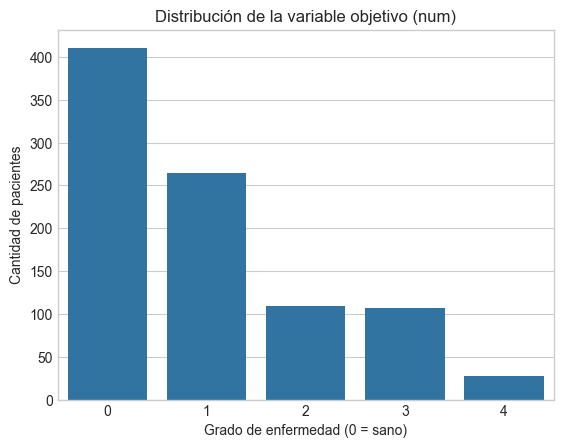

In [157]:
sns.countplot(x='num', data=df)
plt.title('Distribución de la variable objetivo (num)')
plt.xlabel('Grado de enfermedad (0 = sano)')
plt.ylabel('Cantidad de pacientes')
plt.show()

Observo que la clase 0 (sin enfermedad) es mayoritaria, pero hay representación de todos los grados de enfermedad.

# Genero histogramas para visualizar la distribución de cada variable numérica

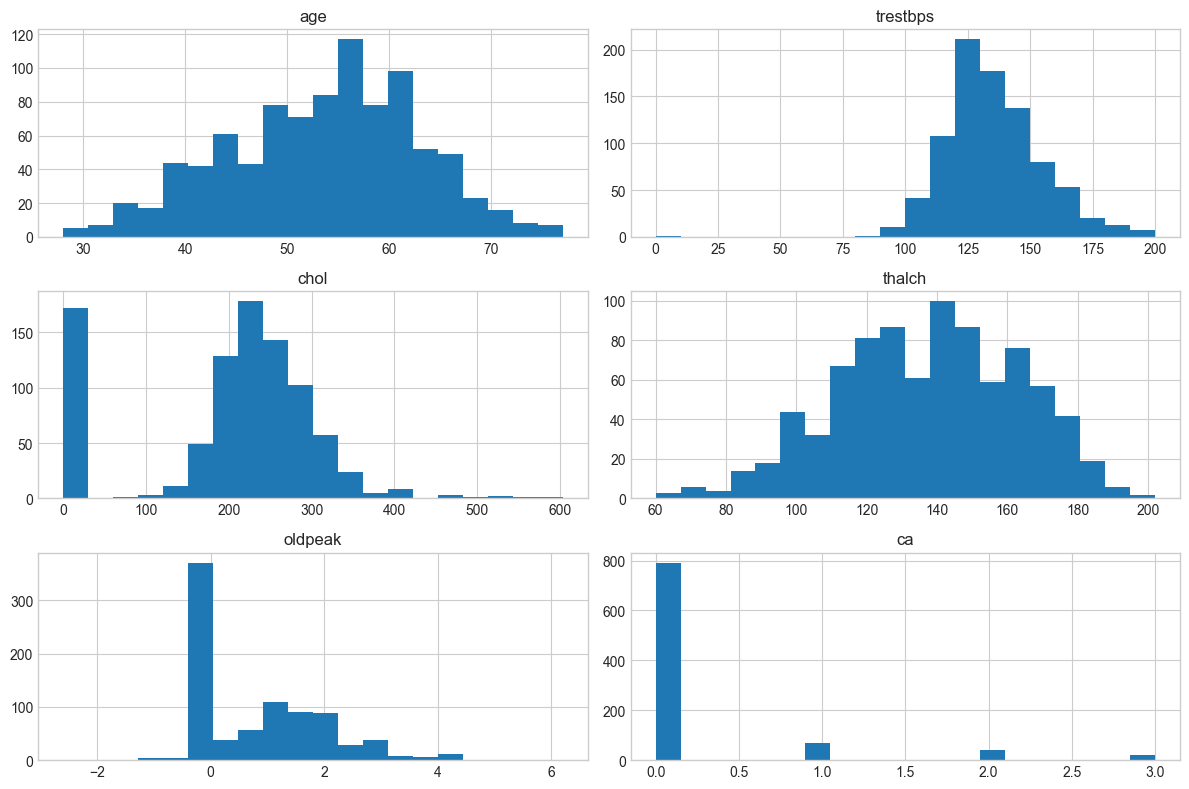

In [158]:
df[num_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

Observo que 'age' tiene una distribución cercana a la normal, mientras que 'ca' (vasos principales) está sesgada hacia cero. Las variables tienen escalas y distribuciones muy diferentes.

# Calculo y visualizo la matriz de correlación entre todas las variables

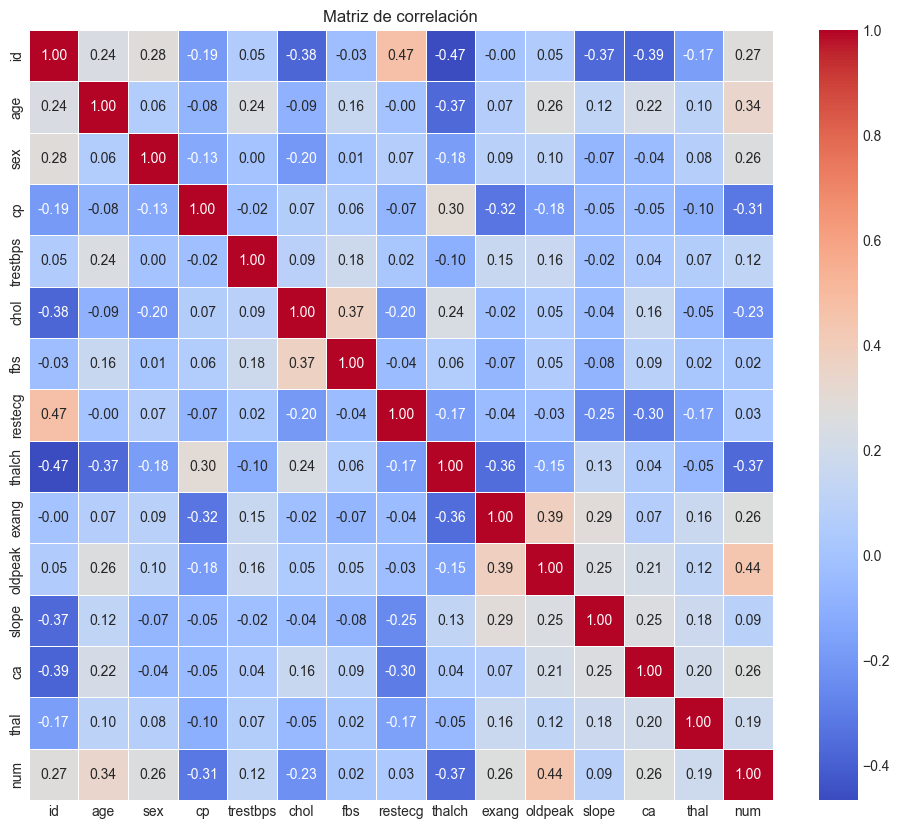

In [159]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Gracias al gráfico puedo identificar correlaciones moderadas entre variables y la enfermedad cardíaca. Por ejemplo: 'thalch' (frecuencia cardíaca) y 'oldpeak' (depresión ST) muestran relación con la variable objetivo.

## 2. Procedimiento de Análisis de Componentes Principales

### 2.1 Separar predictores y objetivo, y estandarizar

PCA requiere que todas las variables estén en la misma escala, por eso estandarizo (media=0, desviación=1). Esto evita que variables con valores grandes dominen el análisis.

In [160]:
X = df.drop('num', axis=1)
y = df['num']

# Selecciono solo columnas numéricas para PCA
X = X.select_dtypes(include=[np.number])

# Elimino filas con valores faltantes
X = X.dropna()
y = y[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,-1.670958,1.050186,0.536807,2.348854,0.679000,0.291349,1.990779,-1.512156,0.474814,-0.804618,1.295742,-0.549700,-0.384010,-2.348537
1,-1.667078,1.478336,0.536807,-0.804559,1.467744,0.773058,-0.062057,-1.512156,-1.152115,1.242826,0.564039,0.338194,4.174496,-0.346228
2,-1.663197,1.478336,0.536807,-0.804559,-0.635573,0.254994,-0.062057,-1.512156,-0.338651,1.242826,1.570131,0.338194,2.654994,1.656082
3,-1.659317,-1.732793,0.536807,1.297716,-0.109744,0.445860,-0.062057,0.080905,1.908061,-0.804618,2.393296,-0.549700,-0.384010,-0.346228
4,-1.655436,-1.304643,-1.862866,0.246579,-0.109744,0.027772,-0.062057,-1.512156,1.327015,-0.804618,0.472576,1.226089,-0.384010,-0.346228


Todas las variables ahora están en la misma escala. Además de que puedo observar la forma del dataset y las primeras filas estandarizadas.

### 2.2 Matriz de covarianza

La matriz de covarianza muestra cómo varían conjuntamente las variables estandarizadas. Es la base para calcular los componentes principales.

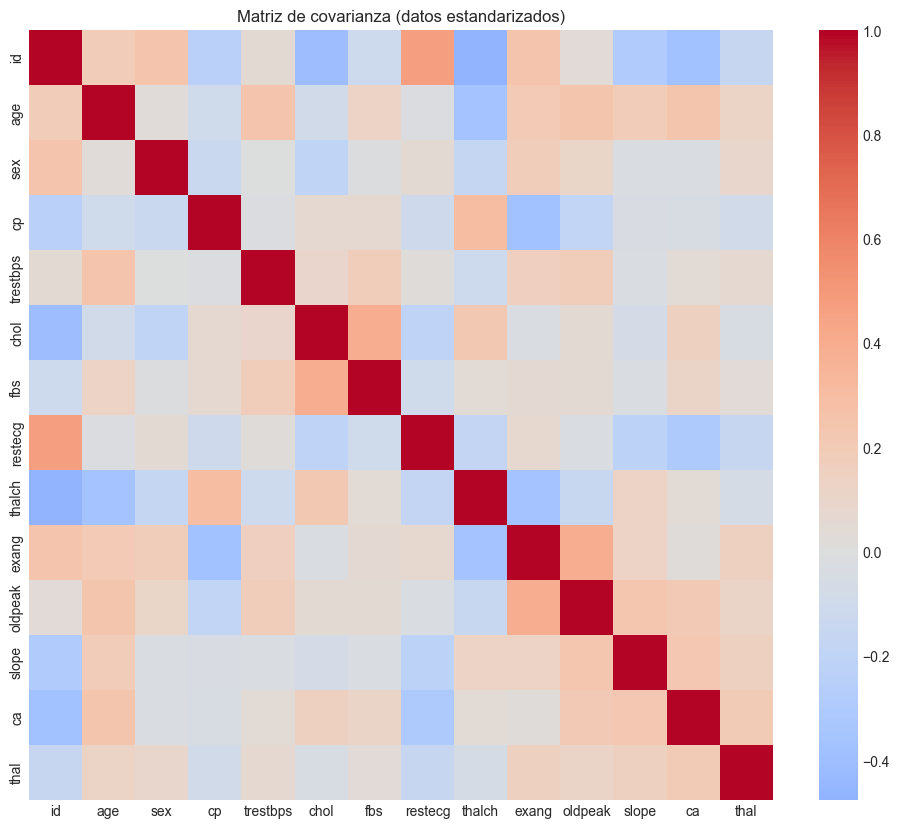

In [161]:
cov_matrix = np.cov(X_scaled.T)

plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, xticklabels=X.columns, yticklabels=X.columns,
            cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de covarianza (datos estandarizados)')
plt.show()

Los colores del heatmap muestran las covarianzas: rojo indica correlaciones positivas y azul indica negativas. 

### 2.3 Eigenvalores y eigenvectores

Los eigenvalores indican la cantidad de varianza explicada por cada componente. Los eigenvectores definen la dirección de los nuevos ejes (componentes principales).

In [162]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Eigenvalores (ordenados de mayor a menor):")
for i, ev in enumerate(eigenvalues[:5]):
    print(f"  PC{i+1}: {ev:.4f}")

print("\nPrimeros 5 eigenvectores (filas = variables, columnas = componentes):")
print(pd.DataFrame(eigenvectors[:, :5], index=X.columns,
                   columns=[f'PC{i+1}' for i in range(5)]).round(3))

Eigenvalores (ordenados de mayor a menor):
  PC1: 2.7058
  PC2: 2.2982
  PC3: 1.4351
  PC4: 1.0766
  PC5: 0.9879

Primeros 5 eigenvectores (filas = variables, columnas = componentes):
            PC1    PC2    PC3    PC4    PC5
id       -0.489 -0.219 -0.099  0.088  0.020
age      -0.226  0.338 -0.084  0.555 -0.011
sex      -0.238  0.025  0.139 -0.255  0.623
cp        0.300 -0.148 -0.073  0.474  0.183
trestbps -0.106  0.215 -0.404  0.314  0.061
chol      0.292  0.175 -0.480 -0.328 -0.105
fbs       0.104  0.210 -0.551 -0.088  0.242
restecg  -0.297 -0.285 -0.152  0.028 -0.212
thalch    0.438 -0.087  0.078 -0.127 -0.071
exang    -0.341  0.290 -0.044 -0.340 -0.153
oldpeak  -0.171  0.387  0.007 -0.142 -0.309
slope     0.086  0.334  0.400  0.114 -0.296
ca        0.151  0.416  0.121  0.108  0.058
thal     -0.013  0.294  0.234 -0.054  0.495


Aquí muestro los eigenvalores y los primeros 5 eigenvectores. Los eigenvectores indican qué peso tiene cada variable original en cada componente.

### 2.4 Varianza explicada

Calculo el porcentaje de varianza que captura cada componente principal. Esto ayuda a poder decidir cuántos componentes conservar.

In [163]:
varianza_explicada = eigenvalues / np.sum(eigenvalues)
varianza_acumulada = np.cumsum(varianza_explicada)

var_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(varianza_explicada))],
    'Varianza explicada (%)': (varianza_explicada * 100).round(2),
    'Varianza acumulada (%)': (varianza_acumulada * 100).round(2)
})
print(var_df)

   Componente  Varianza explicada (%)  Varianza acumulada (%)
0         PC1                   19.30                   19.30
1         PC2                   16.40                   35.70
2         PC3                   10.24                   45.94
3         PC4                    7.68                   53.62
4         PC5                    7.05                   60.67
5         PC6                    6.35                   67.02
6         PC7                    6.06                   73.07
7         PC8                    5.25                   78.33
8         PC9                    4.95                   83.27
9        PC10                    4.71                   87.98
10       PC11                    3.57                   91.56
11       PC12                    3.39                   94.95
12       PC13                    3.01                   97.96
13       PC14                    2.04                  100.00


La tabla muestra la varianza explicada acumulada. Aquí se observa que con 3 variables se puede llegar a un 46% de Varianza acumulada, la cuál no es mucha, pero puede llegar a funcionar en ciertos contextos. 

### 2.5 Scree plot

Gráfico que muestra la varianza explicada por cada componente. Esto ayuda a visualizar el punto donde la ganancia de información disminuye.

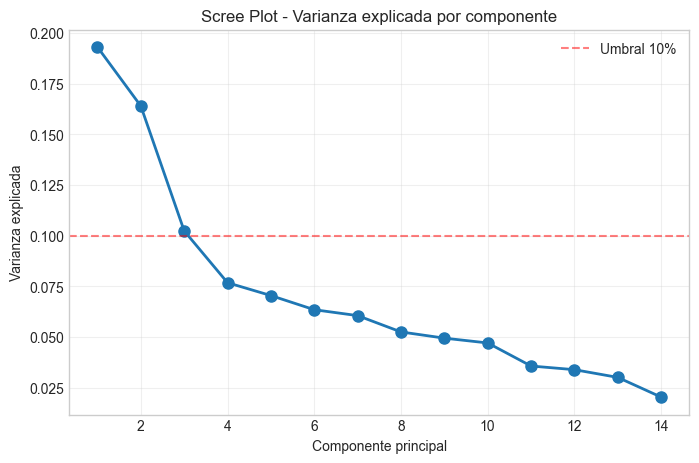

In [164]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada)+1), varianza_explicada, 'o-', linewidth=2, markersize=8)
plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Umbral 10%')
plt.title('Scree Plot - Varianza explicada por componente')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

El gráfico del scree plot muestra un "codo" alrededor del componente 3-4, indicando dónde la ganancia de información disminuye con mayor fuerza.

### 2.6 Proyección a los primeros 3 componentes principales

Reduzco los datos a 3 dimensiones y grafico en 3D coloreando por la variable objetivo.

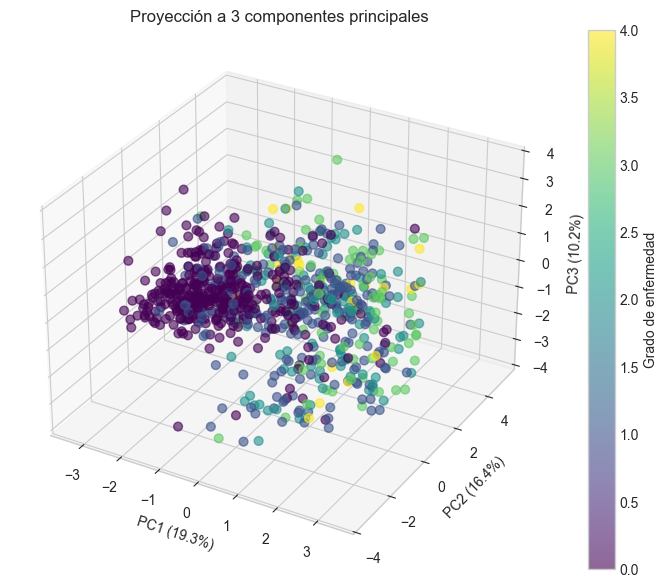

In [165]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

df_pca_3 = pd.DataFrame(X_pca_3, columns=['PC1', 'PC2', 'PC3'])
df_pca_3['num'] = y.values

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca_3['PC1'], df_pca_3['PC2'], df_pca_3['PC3'],
                     c=df_pca_3['num'], cmap='viridis', s=40, alpha=0.6)
ax.set_xlabel(f'PC1 ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca_3.explained_variance_ratio_[2]*100:.1f}%)')
plt.title('Proyección a 3 componentes principales')
plt.colorbar(scatter, label='Grado de enfermedad')
plt.show()

En la gráfica 3D se observa cierta separación entre pacientes sanos (color oscuro) y enfermos (color más claro), aunque hay superposición. Esto podría significar que los datos tienen estructura pero no son linealmente separables en estas dimensiones.

### 2.7 Proyección a los primeros 2 componentes principales

Reduzco a 2 dimensiones para poder visualizarlo de manera más sencilla.

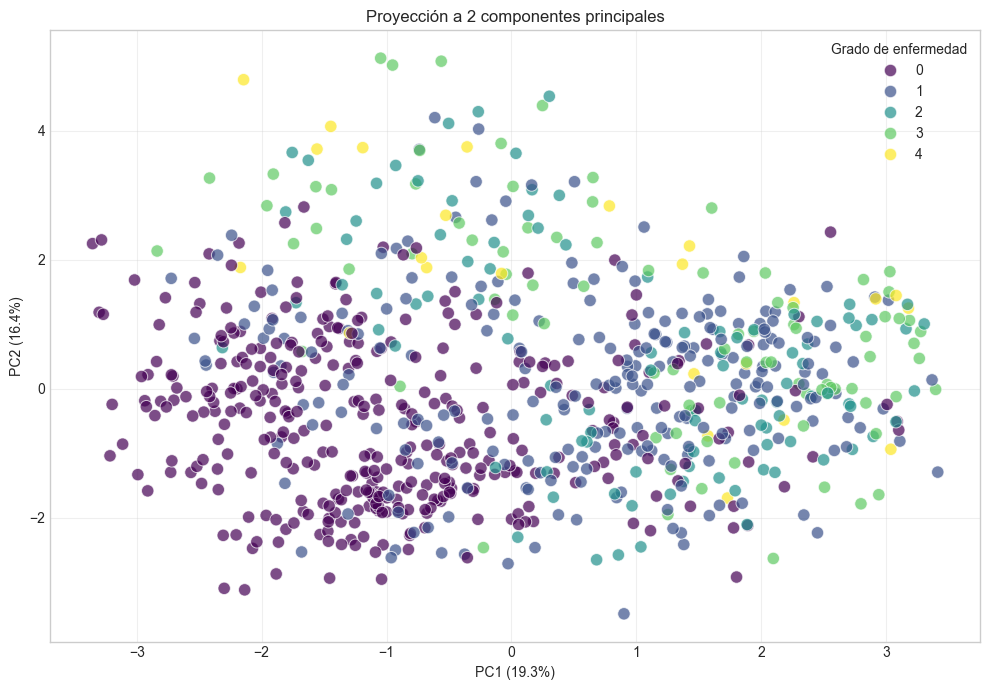

In [166]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

df_pca_2 = pd.DataFrame(X_pca_2, columns=['PC1', 'PC2'])
df_pca_2['num'] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca_2, x='PC1', y='PC2', hue='num', palette='viridis', alpha=0.7, s=80)
plt.xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Proyección a 2 componentes principales')
plt.legend(title='Grado de enfermedad', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

En el gráfico 2D se puede ver mejor: los pacientes con enfermedad más severa comunmente están hacia la derecha (valores altos de PC1) y arriba (PC2), aunque hay mezcla. Esto puede indicar que estos componentes capturan información relevante para poder discriminar entre clases.

## 3. Conclusiones

**Efectividad de PCA:** Para este conjunto de datos, PCA permitió reducir la dimensionalidad de 13 variables a 3 componentes, que explican solo el 46% de la varianza. Aunque facilita la visualización, este porcentaje es relativamente bajo, lo que indica que los datos no se comprimen bien en pocas dimensiones.

**Análisis:** Las variables con mayor peso en los primeros componentes son `thalch` (dominante en PC1), y `ca`, `oldpeak` (dominantes en PC2), lo que coincide con la literatura médica sobre factores de riesgo cardíaco.

**Modelos de clasificación:** El espacio reducido conserva cierta separación entre clases (como se ve en los gráficos 2D y 3D), por lo que podría ser útil como entrada para redes neuronales u otros clasificadores. Aunque, la superposición indica que se necesitarían modelos no lineales o características adicionales para mejorar la precisión.

**Enlace al repositorio de GitHub:**
https://github.com/SaZ03/02-Principal-Component-Analysis

## 4. Referencias

- **Dataset:** UCI Machine Learning Repository. Heart Disease Data Set.
  https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download

- **Documentación de scikit-learn:** PCA.
  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

- **Material del curso** proporcionado por el Dr. Andrés Hernández Gutiérrez.